In [18]:
# Global imports
import numpy as np
from time import time
from torch.autograd import Variable
import torchvision
import matplotlib.pyplot as plt
import torch.utils.data

# Imports from support classes
from SupportClasses import SupportClass as sc
from SupportClasses import DCGAN as dg
from SupportClasses import WGAN as wg
from SupportClasses import VAE as vae

In [2]:
# Code cell for preparing data

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

mnist_train_set, mnist_test_set = sc.download_mnist()
cifar_train_set, cifar_test_set = sc.download_cifar10()

mnist_train_loader, mnist_test_loader = sc.create_data_loaders(mnist_train_set, mnist_test_set)
cifar_train_loader, cifar_test_loader = sc.create_data_loaders(cifar_train_set, cifar_test_set)

# Other global values

cuda:0
Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Code cell for preparing the DCGAN model
opt = dg.Opt()
img_shape = (opt.channels, opt.img_size, opt.img_size)

# Define the loss, generator and discriminator
bce_loss = torch.nn.BCELoss()
dcgan_generator = dg.Generator(img_shape=img_shape, opt=opt)
dcgan_discriminator = dg.Discriminator(img_shape=img_shape)

# Send the models to the device we're working with
dcgan_generator.to(device=device)
dcgan_discriminator.to(device=device)
bce_loss.to(device=device)

# Define the optimizers for the generator and discriminator.
dcgan_generator_optimizer = torch.optim.Adam(dcgan_generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
dcgan_discriminator_optimizer = torch.optim.Adam(dcgan_discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

In [4]:
# Code cell for training the DCGAN model
dcgan_saved_imgs = []
per_epoch_jsd = []
for epoch in range(opt.n_epochs):
    start_time = time()
    gen_imgs_tensor = None
    for i, (imgs, _) in enumerate(mnist_train_loader):
        real = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)
        real_imgs = Variable(imgs.type(Tensor))

        # Train the generator
        dcgan_generator_optimizer.zero_grad()

        # Get noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))

        # Generate a batch of images
        gen_imgs = dcgan_generator(z)

        # Calculate the generator's loss. Its ability to fool the generator
        dcgan_generator_loss = bce_loss(dcgan_discriminator(gen_imgs), real)
        dcgan_generator_loss.backward()
        dcgan_generator_optimizer.step()

        # Train the discriminator
        dcgan_discriminator.zero_grad()

        # Measure the discriminator's loss. Its ability to determine real from fake.
        real_loss = bce_loss(dcgan_discriminator(real_imgs), real)
        fake_loss = bce_loss(dcgan_discriminator(gen_imgs.detach()), fake)

        discriminator_loss = (real_loss + fake_loss) / 2
        discriminator_loss.backward()
        dcgan_discriminator_optimizer.step()
        batches_done = epoch * len(mnist_train_loader) + i

        # Add these values to the generated images tensor
        if gen_imgs_tensor is None:
            gen_imgs_tensor = gen_imgs.cpu()
        else:
            gen_imgs_tensor = torch.cat((gen_imgs_tensor, gen_imgs.cpu()), 0)
    end_time = time()

    # Here we will calculate the JSD for the epoch
    jsd = dg.calculate_jsd(gen_imgs_tensor, mnist_train_set.data)
    per_epoch_jsd.append(jsd)

    # Get the time to perform this epoch
    epoch_mins, epoch_secs = sc.epoch_time(start_time, end_time)
    print(f'Epoch: {epoch+1:02} | Jensen Shannon Divergence: {jsd} | Epoch time (Baseline Training): {epoch_mins}m {epoch_secs}s')
    grid = torchvision.utils.make_grid(gen_imgs.data.cpu(), nrow=opt.dim)
    img = (np.transpose(grid.detach().numpy(), (1, 2 ,0)) * 255).astype(np.uint8)
    dcgan_saved_imgs.append(img)

AttributeError: 'Subset' object has no attribute 'data'

KeyboardInterrupt: 

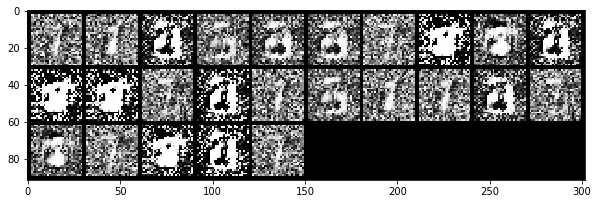

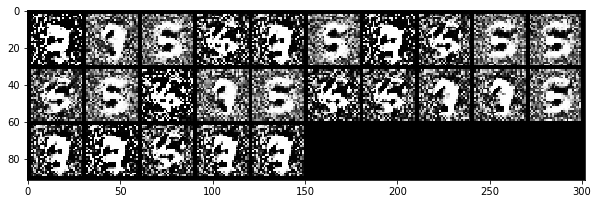

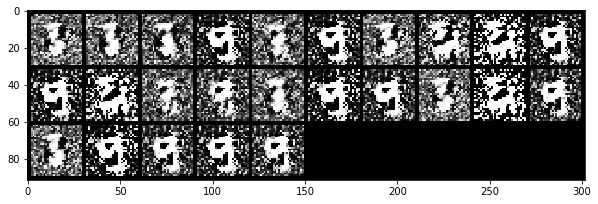

In [6]:
img_indexes = [0, 49, 99, 149, 199]
for i in img_indexes:
    plt.figure(figsize = (opt.dim, opt.dim))
    plt.imshow(dcgan_saved_imgs[i], interpolation='nearest')

# Plot Jensen Shannon Divergence

In [5]:
# Code cell for preparing the WGAN
opt = wg.Opt()
img_shape = (opt.channels, opt.img_size, opt.img_size)

# Define the generator and discriminator
wgan_generator = wg.Generator(img_shape=img_shape, opt=opt)
wgan_discriminator = wg.Discriminator(opt=opt)

# Send the models to the device we're working with
wgan_generator.to(device=device)
wgan_discriminator.to(device=device)

# Define the optimizers for the generator and discriminator.
wgan_generator_optimizer = torch.optim.RMSprop(wgan_generator.parameters(), lr=opt.lr)
wgan_discriminator_optimizer = torch.optim.RMSprop(wgan_discriminator.parameters(), lr=opt.lr)

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

In [9]:
# Code cell for training the WGAN model
batches_done = 0
wgan_saved_imgs = []
for epoch in range(opt.n_epochs):
    start_time = time()
    for i, (imgs, _) in enumerate(mnist_train_loader):
        real_imgs = Variable(imgs.type(Tensor))
        # train Discriminator
        wgan_discriminator_optimizer.zero_grad()
        # sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))
        # generate a batch of images
        fake_imgs = wgan_generator(z).detach()
        # Adversarial loss
        discriminator_loss = torch.mean(wgan_discriminator(fake_imgs)) - torch.mean(wgan_discriminator(real_imgs))
        discriminator_loss.backward()
        wgan_discriminator_optimizer.step()
        # clip weights of discriminator
        for p in wgan_discriminator.parameters():
            p.data.clamp_(-opt.clip_value, opt.clip_value)
        # train the generator every n_critic iterations
        if i % opt.n_critic == 0:
            # train Generator
            wgan_generator_optimizer.zero_grad()
            # generate a batch of fake images
            critics_fake_imgs = wgan_generator(z)
            # Adversarial loss
            generator_loss = -torch.mean(wgan_discriminator(critics_fake_imgs))
            generator_loss.backward()
            wgan_generator_optimizer.step()
        batches_done += 1
    end_time = time()

    # Get the Earth Mover's Distance
    # TODO: Implement Earth Mover's Distance

    # Get the time to perform this epoch
    epoch_mins, epoch_secs = sc.epoch_time(start_time, end_time)
    print(f'Epoch: {epoch+1:02} | Earth Mover\'s Distance: 0 | Epoch time (Baseline Training): {epoch_mins}m {epoch_secs}s')
    grid = torchvision.utils.make_grid(critics_fake_imgs.data.cpu(), nrow=opt.dim)
    img = (np.transpose(grid.detach().numpy(), (1, 2 ,0)) * 255).astype(np.uint8)
    wgan_saved_imgs.append(img)

Epoch: 01 | Earth Mover's Distance: 0 | Epoch time (Baseline Training): 0m 13s
Epoch: 02 | Earth Mover's Distance: 0 | Epoch time (Baseline Training): 0m 13s
Epoch: 03 | Earth Mover's Distance: 0 | Epoch time (Baseline Training): 0m 12s
Epoch: 04 | Earth Mover's Distance: 0 | Epoch time (Baseline Training): 0m 13s
Epoch: 05 | Earth Mover's Distance: 0 | Epoch time (Baseline Training): 0m 12s
Epoch: 06 | Earth Mover's Distance: 0 | Epoch time (Baseline Training): 0m 12s
Epoch: 07 | Earth Mover's Distance: 0 | Epoch time (Baseline Training): 0m 12s
Epoch: 08 | Earth Mover's Distance: 0 | Epoch time (Baseline Training): 0m 13s
Epoch: 09 | Earth Mover's Distance: 0 | Epoch time (Baseline Training): 0m 12s
Epoch: 10 | Earth Mover's Distance: 0 | Epoch time (Baseline Training): 0m 12s
Epoch: 11 | Earth Mover's Distance: 0 | Epoch time (Baseline Training): 0m 12s
Epoch: 12 | Earth Mover's Distance: 0 | Epoch time (Baseline Training): 0m 12s
Epoch: 13 | Earth Mover's Distance: 0 | Epoch time (

KeyboardInterrupt: 

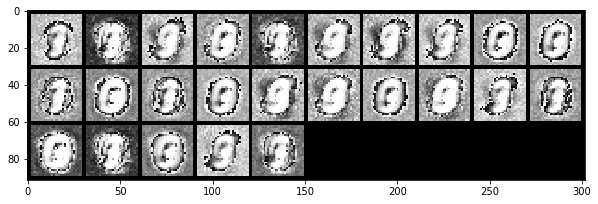

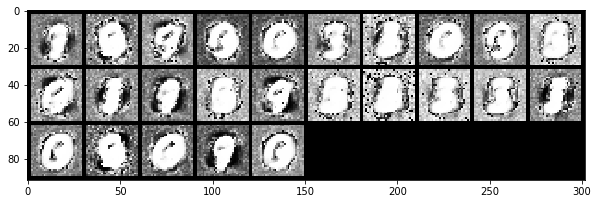

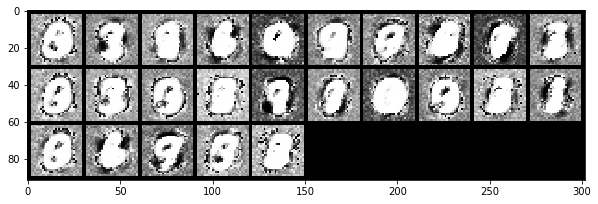

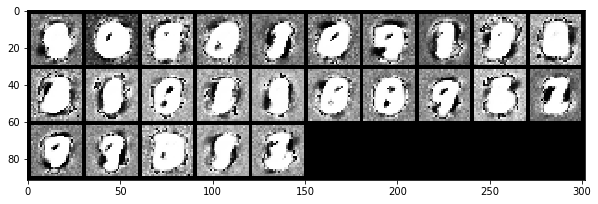

In [10]:
img_indexes = [0, 49, 99, 149, 199]
for i in img_indexes:
    plt.figure(figsize = (opt.dim, opt.dim))
    plt.imshow(wgan_saved_imgs[i], interpolation='nearest')

# Plot Earth Mover's Distance

In [14]:
# Code cell for preparing the VAE

# Global values for training
latent_dims = 2
epochs = 50

autoencoder = vae.VariationalAutoencoder(latent_dims).to(device) # GPU

In [16]:
# Code cell for training the VAE model

opt = torch.optim.Adam(autoencoder.parameters())
reconstruction_loss = []

for epoch in range(epochs):
    start_time = time()
    running_loss = 0
    for x, y in mnist_train_loader:
        x = x.to(device=device)  # GPU
        opt.zero_grad()
        x_hat = autoencoder(x)
        loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
        running_loss += loss.item()
        loss.backward()
        opt.step()
    end_time = time()
    # Get the time to training
    epoch_mins, epoch_secs = sc.epoch_time(start_time, end_time)

    # Print the output if the number of epochs is equal to one in this list
    if epoch in [0, 49, 99, 149, 199]:
        vae.plot_reconstructed(autoencoder, device, r0=(-3, 3), r1=(-3, 3))

    # Append to the reconstruction loss
    reconstruction_loss.append(running_loss / len(mnist_train_set.data))

    # Print some output from this epoch
    print(f'Epoch: {epoch+1:02} | Epoch time (VAE Training): {epoch_mins}m {epoch_secs}s')
    print(f'\t Mean reconstruction loss: {reconstruction_loss[epoch]:.5f}')

Epoch: 01 | Epoch time (VAE Training): 0m 12s
	 Mean reconstruction loss: 532.51439
Epoch: 02 | Epoch time (VAE Training): 0m 12s
	 Mean reconstruction loss: 530.04075
Epoch: 03 | Epoch time (VAE Training): 0m 12s
	 Mean reconstruction loss: 527.94588
Epoch: 04 | Epoch time (VAE Training): 0m 12s
	 Mean reconstruction loss: 526.96349
Epoch: 05 | Epoch time (VAE Training): 0m 12s
	 Mean reconstruction loss: 525.98938
Epoch: 06 | Epoch time (VAE Training): 0m 12s
	 Mean reconstruction loss: 525.25412
Epoch: 07 | Epoch time (VAE Training): 0m 12s
	 Mean reconstruction loss: 524.37291
Epoch: 08 | Epoch time (VAE Training): 0m 12s
	 Mean reconstruction loss: 524.13874
Epoch: 09 | Epoch time (VAE Training): 0m 12s
	 Mean reconstruction loss: 523.30189
Epoch: 10 | Epoch time (VAE Training): 0m 12s
	 Mean reconstruction loss: 522.89122
Epoch: 11 | Epoch time (VAE Training): 0m 12s
	 Mean reconstruction loss: 522.45210
Epoch: 12 | Epoch time (VAE Training): 0m 12s
	 Mean reconstruction loss: 52

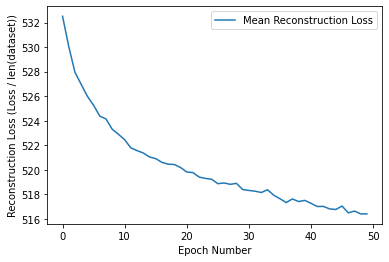

In [22]:
# Plot the reconstruction loss
plt.plot([i for i in range(epochs)], reconstruction_loss, label='Mean Reconstruction Loss')

# Add a legend
plt.legend()

# Add labels
plt.xlabel("Epoch Number")
plt.ylabel("Reconstruction Loss (Loss / len(dataset))")

# Show the plot
plt.show()
